In [9]:
%load_ext autoreload
%autoreload 2

import os
import pickle

from config import Config

import matplotlib.pyplot as plt
import numpy as np
from utility import format_decomp_name, format_dataset_name

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "Times New Roman"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
RESULTS_FOLDER = "results/experiment_5/"
c = Config()
algorithm_names = c.algorithm_names_generic_intra

In [11]:
evaluation_metric = "mae"
all_errors = np.full((len(algorithm_names),len(c.dataset_names),len(c.decomp_intra_names), len(c.metrics)), -1.0)

for i, algorithm in enumerate(algorithm_names):
    folder = RESULTS_FOLDER + algorithm + "/"
    for j, dataset in enumerate(c.dataset_names):
        if not os.path.exists(folder + dataset + ".pkl"):
            continue
        with open(folder + dataset + ".pkl", "rb") as file:
            errors = pickle.load(file)
            for k, decomp in enumerate(c.decomp_intra_names):
                for l, metric in enumerate(c.metrics):
                    if decomp not in errors.keys():
                        # trend-seasonality doesnt work for all datasets (due to non-existant period)
                        # replace with moving average decomp
                        all_errors[i,j,k,l] = errors["moving_avg"][metric]
                        continue
                    all_errors[i,j,k,l] = errors[decomp][metric]
trend_seasonality_index = c.decomp_intra_names.index("trend_seasonality")
period_1_datasets = [c.dataset_names.index(d) for d in c.dataset_names if c.periods[d] == 1]
short_datasets = [c.dataset_names.index(d) for d in c.short_datasets]
long_datasets = [c.dataset_names.index(d) for d in c.long_datasets]

# Replace the period=1 dataset results with the none-results
all_errors[:,period_1_datasets,trend_seasonality_index,:] = None

mae = all_errors[...,c.metrics.index(evaluation_metric)]

/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_49174/17386251.py:4: RuntimeWarning: Mean of empty slice
  mean_short = np.nanmean(error_reduction[short_datasets,:],axis=0,keepdims=True)
/var/folders/y9/3vmyk1sj3gdg57c8wdhmps4m0000gp/T/ipykernel_49174/17386251.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


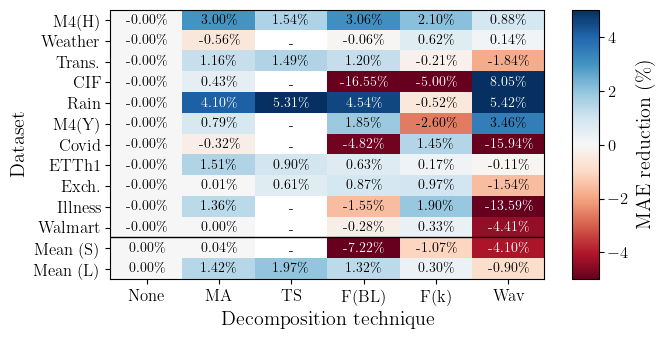

In [12]:
for i, algorithm in enumerate(c.algorithm_names_generic_intra):
    mae_algo = mae[i]
    error_reduction = 100 * -(mae_algo - mae_algo[:,:1]) / mae_algo[:,:1]
    mean_short = np.nanmean(error_reduction[short_datasets,:],axis=0,keepdims=True)
    mean_long = np.nanmean(error_reduction[long_datasets,:],axis=0,keepdims=True)
    error_reduction = np.concatenate([error_reduction, mean_short, mean_long],axis=0)
    # mean = np.nanmean(error_reduction,axis=0,keepdims=True)
    # error_reduction = np.concatenate([error_reduction, mean],axis=0)
    clim = 5
    # clim = np.max(np.abs(error_reduction))

    fig, ax = plt.subplots(figsize=(7,3.5))
    imshow = ax.imshow(error_reduction, cmap="RdBu", aspect="auto")
    cbar = fig.colorbar(imshow, aspect=10)
    imshow.set_clim(-clim,clim)
    cbar.ax.tick_params(labelsize="large")
    cbar.set_label("MAE reduction (\%)", fontdict={"fontsize": "x-large"})

    for k in range(error_reduction.shape[0]):
        for j in range(error_reduction.shape[1]):
            value = error_reduction[k, j]
            color = "w" if np.abs(value) > 0.7*clim else "black"
            if np.isnan(value):
                t = "-"
            else:
                t = f"{value:.2f}\%" if value <= 0 else f"{value:.2f}\%"
            text = ax.text(j, k, t, ha="center", va="center", color=color)

    ax.set_xticks(np.arange(len(c.decomp_intra_names)), [format_decomp_name(name, long=False) for name in c.decomp_intra_names], fontdict={"fontsize": "large"})
    ax.set_xlabel("Decomposition technique", fontdict={"fontsize": "x-large"})
    ax.set_yticks(np.arange(len(c.dataset_names)+2), [format_dataset_name(name,long=False) for name in c.dataset_names+["Mean (S)", "Mean (L)"]], fontdict={"fontsize": "large"})
    ax.set_ylabel("Dataset", fontdict={"fontsize": "x-large"})
    ax.hlines(len(c.dataset_names)-0.55,ax.get_xlim()[0],ax.get_xlim()[1],color="black",lw=1)
    fig.show()
    fig.savefig(f"plots/{algorithm}_improvement_by_decomp.pdf",bbox_inches="tight")